<a href="https://colab.research.google.com/github/abdellatif2/slick/blob/master/Copie_de_ML_walls.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lateral force on timber walls prediction using machine learning

The goal of this study is to train a machine learning model to predict the  force-displacement response of CLT walls, using data generated using a FEM model.

In [ ]:
# importing libraries

import pandas as pd # for tabular data manهpعlation
import matplotlib.pyplot as plt # data visualization
import numpy as np # linear algebra
import seaborn as sns # data visualization

from sklearn.model_selection import train_test_split # for splitting the data
from sklearn.linear_model import LinearRegression # simple linear regression model
from sklearn.ensemble import RandomForestRegressor # random forest model
from sklearn.preprocessing import StandardScaler # standard scaling transformer
from sklearn.metrics import mean_squared_error # MSE function

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 1-The data

The data consist of a table that contains the characteristics of the wall (length, height, thickness...) and the results of the strength analysis. 

Using this inputs, we'll calculate the force-displacement response of the wall.


In [ ]:
Mechanisms = ['Bending', 'Shear', 'Rocking', 'Sliding']
tol = 1E-06

# INPUT VARIABLES
# ----------------------------
# Wall
L = 3.0 # m | length of wall
H = 3.0 # m | height of wall
t = 0.2 # m | thickness of wall
E_eff = 6000E03 # kPa | effective modulus of elasticity
M_wy = 500.0 # kNm | bending strength
d_w_b = 1.5 # - | maximum bending ductility
G_eff = 450E03 # kPa | effective shear modulus
V_wy = 200.0 # kN | shear strength
d_w_s = 1.3 # - | maximum shear ductility
q = 30.0 # kN/m | vertical load at top of wall
e_r = 0.1 # - | distance of rotation centre from edge wrt L
 
# Hold-down
k_h = 1000.0 # kN/m | stiffness
F_hy = 480.0 # kN | strength
d_h = 10.0 # - | maximum ductility
e_h = 0.1 # - | distance of hold-down from edge wrt L
 
# Angle-bracket
k_a = 3000.0 # kN/m | stiffness
F_ay = 80.0 # kN | strength
d_a = 5.0 # - | maximum ductility
 
# Strength Analysis
R_w_b = M_wy / L # kN | lateral resistance from bending of wall
R_w_s = V_wy # kN | lateral resistance from shear of wall
R_h = (F_hy * (1 - e_h - e_r) + q * L * (0.5 - e_r)) * L / H # kN | lateral resistance from overturning of wall
R_a = F_ay # kN | lateral resistance from shear in angle-brackets of wall
 
# ----------------------------

# OUTPUT VARIABLES : Force and displacement
# initialisation of the output as 0
F= 0.0
D= 0.0

In [ ]:
# Creating a datapoint

datapoint = {'L':L, 
        'H':H, 
        't':t, 
        'E_eff':E_eff, 
        'M_wy':M_wy, 
        'd_w_b':d_w_b,
        'G_eff':G_eff,
        'V_wy':V_wy,
       'd_w_s':d_w_s,
        'q':q, 
        'e_r':e_r, 
        'k_h':k_h, 
        'F_hy':F_hy, 
        'd_h':d_h, 
        'e_h':e_h, 
        'k_a':k_a, 
        'F_ay':F_ay, 
        'd_a':d_a,
       'R_w_b':R_w_b,
        'R_w_s':R_w_s, 
        'R_h':R_h, 
        'R_a':R_a,
        'F':F,
        'D':D

}

datapoint = pd.DataFrame(datapoint,index=[0])


In [ ]:
datapoint.head()

,L,H,t,E_eff,M_wy,d_w_b,G_eff,V_wy,d_w_s,q,e_r,k_h,F_hy,d_h,e_h,k_a,F_ay,d_a,R_w_b,R_w_s,R_h,R_a,F,D
0,3.0,3.0,0.2,6000000.0,500.0,1.5,450000.0,200.0,1.3,30.0,0.1,1000.0,480.0,10.0,0.1,3000.0,80.0,5.0,166.666667,200.0,420.0,80.0,0.0,0.0


### 1-1- The Response model

To complete the dataset, we need to calculate the response using the input variables.

In [ ]:
def force_dep( L,	H, t,	E_eff,	M_wy,	d_w_b,	G_eff,	V_wy,	d_w_s,	q,	e_r,	k_h,	F_hy,	d_h,	e_h,	k_a,	F_ay,	d_a,	R_w_b,	R_w_s,	R_h,	R_a, tol, graph=True):
  ''' Takes input variables and returns 2 arrays with F and D
  
  Parameters:
  Input variables (float)

  Returns:                  
  D : list of floats
  F : list of floats
  
  '''
  R_w = min(R_w_b, R_w_s, R_h, R_a)
  MechanismsResistance = [R_w_b, R_w_s, R_h, R_a]

  F_g = q * L * (0.5 - e_r) * L / H # kN | force where overturning initiates


  #for (mech, res) in list(zip(Mechanisms, MechanismsResistance)):
  #    print('Resistance in %s = %.2f kN' %(mech, res))
  #print('\n')
  #print('Resistance due to gravity = %.2f kN' %F_g)

  # Stiffness Analysis
  r = H / L

  k_w_b = E_eff * t / 4 / r ** 3
  k_w_s = (5 / 6) * G_eff * t / r
  k_w_h = (((1 - e_h - e_r) / r) ** 2) * k_h
  k_w_a = k_a

  D = [0.0]
  F = [0.0]

  D_prev = 0.0
  F_prev = 0.0
  if abs(F_g) <= tol: # No gravity resistance
      F_cur = R_w
      K_w = 1 / (1 / k_w_b + 1 / k_w_s + 1 / k_w_h + 1 / k_w_a)
      F.append(F_cur)
      D.append(D_prev + (F_cur - F_prev) / K_w)
      D_prev = D[-1]
      F_prev = F[-1]

  else:
      if F_g < R_w: # No overturning in first phase
          F_cur = F_g
          K_w = 1 / (1 / k_w_b + 1 / k_w_s + 1 / k_w_a)
          F.append(F_cur)
          D.append(D_prev + (F_cur - F_prev) / K_w)
          D_prev = D[-1]
          F_prev = F[-1]

          F_cur = R_w
          K_w = 1 / (1 / k_w_b + 1 / k_w_s + 1 / k_w_h + 1 / k_w_a)
          F.append(F_cur)
          D.append(D_prev + (F_cur - F_prev) / K_w)
          D_prev = D[-1]
          F_prev = F[-1]

      else: # No overturning
          F_cur = R_w
          K_w = 1 / (1 / k_w_b + 1 / k_w_s + 1 / k_w_a)
          F.append(F_cur)
          D.append(D_prev + (F_cur - F_prev) / K_w)
          D_prev = D[-1]
          F_prev = F[-1]

  i_FM = [R_w_b, R_w_s, R_h, R_a].index(F_prev)
  FailureMechanism = Mechanisms[i_FM]
  #print('Failure Mechanism is: %s' %FailureMechanism)

  F.append(F_prev)

  deltaD = [R_w / k_w_b * d_w_b, R_w / k_w_s * d_w_s, (R_w - F_g) / k_w_h * d_h, R_w / k_w_a * d_a][i_FM]
  D.append(D_prev + deltaD)

  # ploting F=f(D)
  if graph==True:
    plt.plot(D,F, lineWidth=3, marker='o')
    plt.grid()
    plt.xlabel('Lateral Displacement [m]')
    plt.ylabel('Lateral Force [kN]')
    plt.show()

  return D ,F

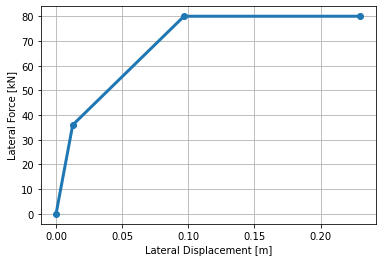

Force:  [0.0, 36.0, 80.0, 80.0]
Displacement:  [0.0, 0.012599999999999998, 0.09674999999999997, 0.2300833333333333]


In [ ]:
# the response of our datapoint
D,F=force_dep(L,	H,	t,	E_eff,	M_wy,	d_w_b,	G_eff,	V_wy,	d_w_s,	q,	e_r,	k_h,	F_hy,	d_h,	e_h,	k_a,	F_ay,	d_a,	R_w_b,	R_w_s,	R_h,	R_a, tol)
print("Force: ",F)
print("Displacement: ",D)

### 1-2- Creating the dataset

Training a machine learning model requirs a lot of data (it depends on the complexity of the problem, and the algorithm used, but usually +1000 is a good start). 
To create this dataset, we assume that the input variables distribution is normal, and create a random normal distribution from the points we already have.

For example: assuming that the the mean of most used panels is around 6 m, we can create a distribution with 500 points, 99% of them are between 6-3*1=3m and 6+3*1=9m.





<div style="align:center">


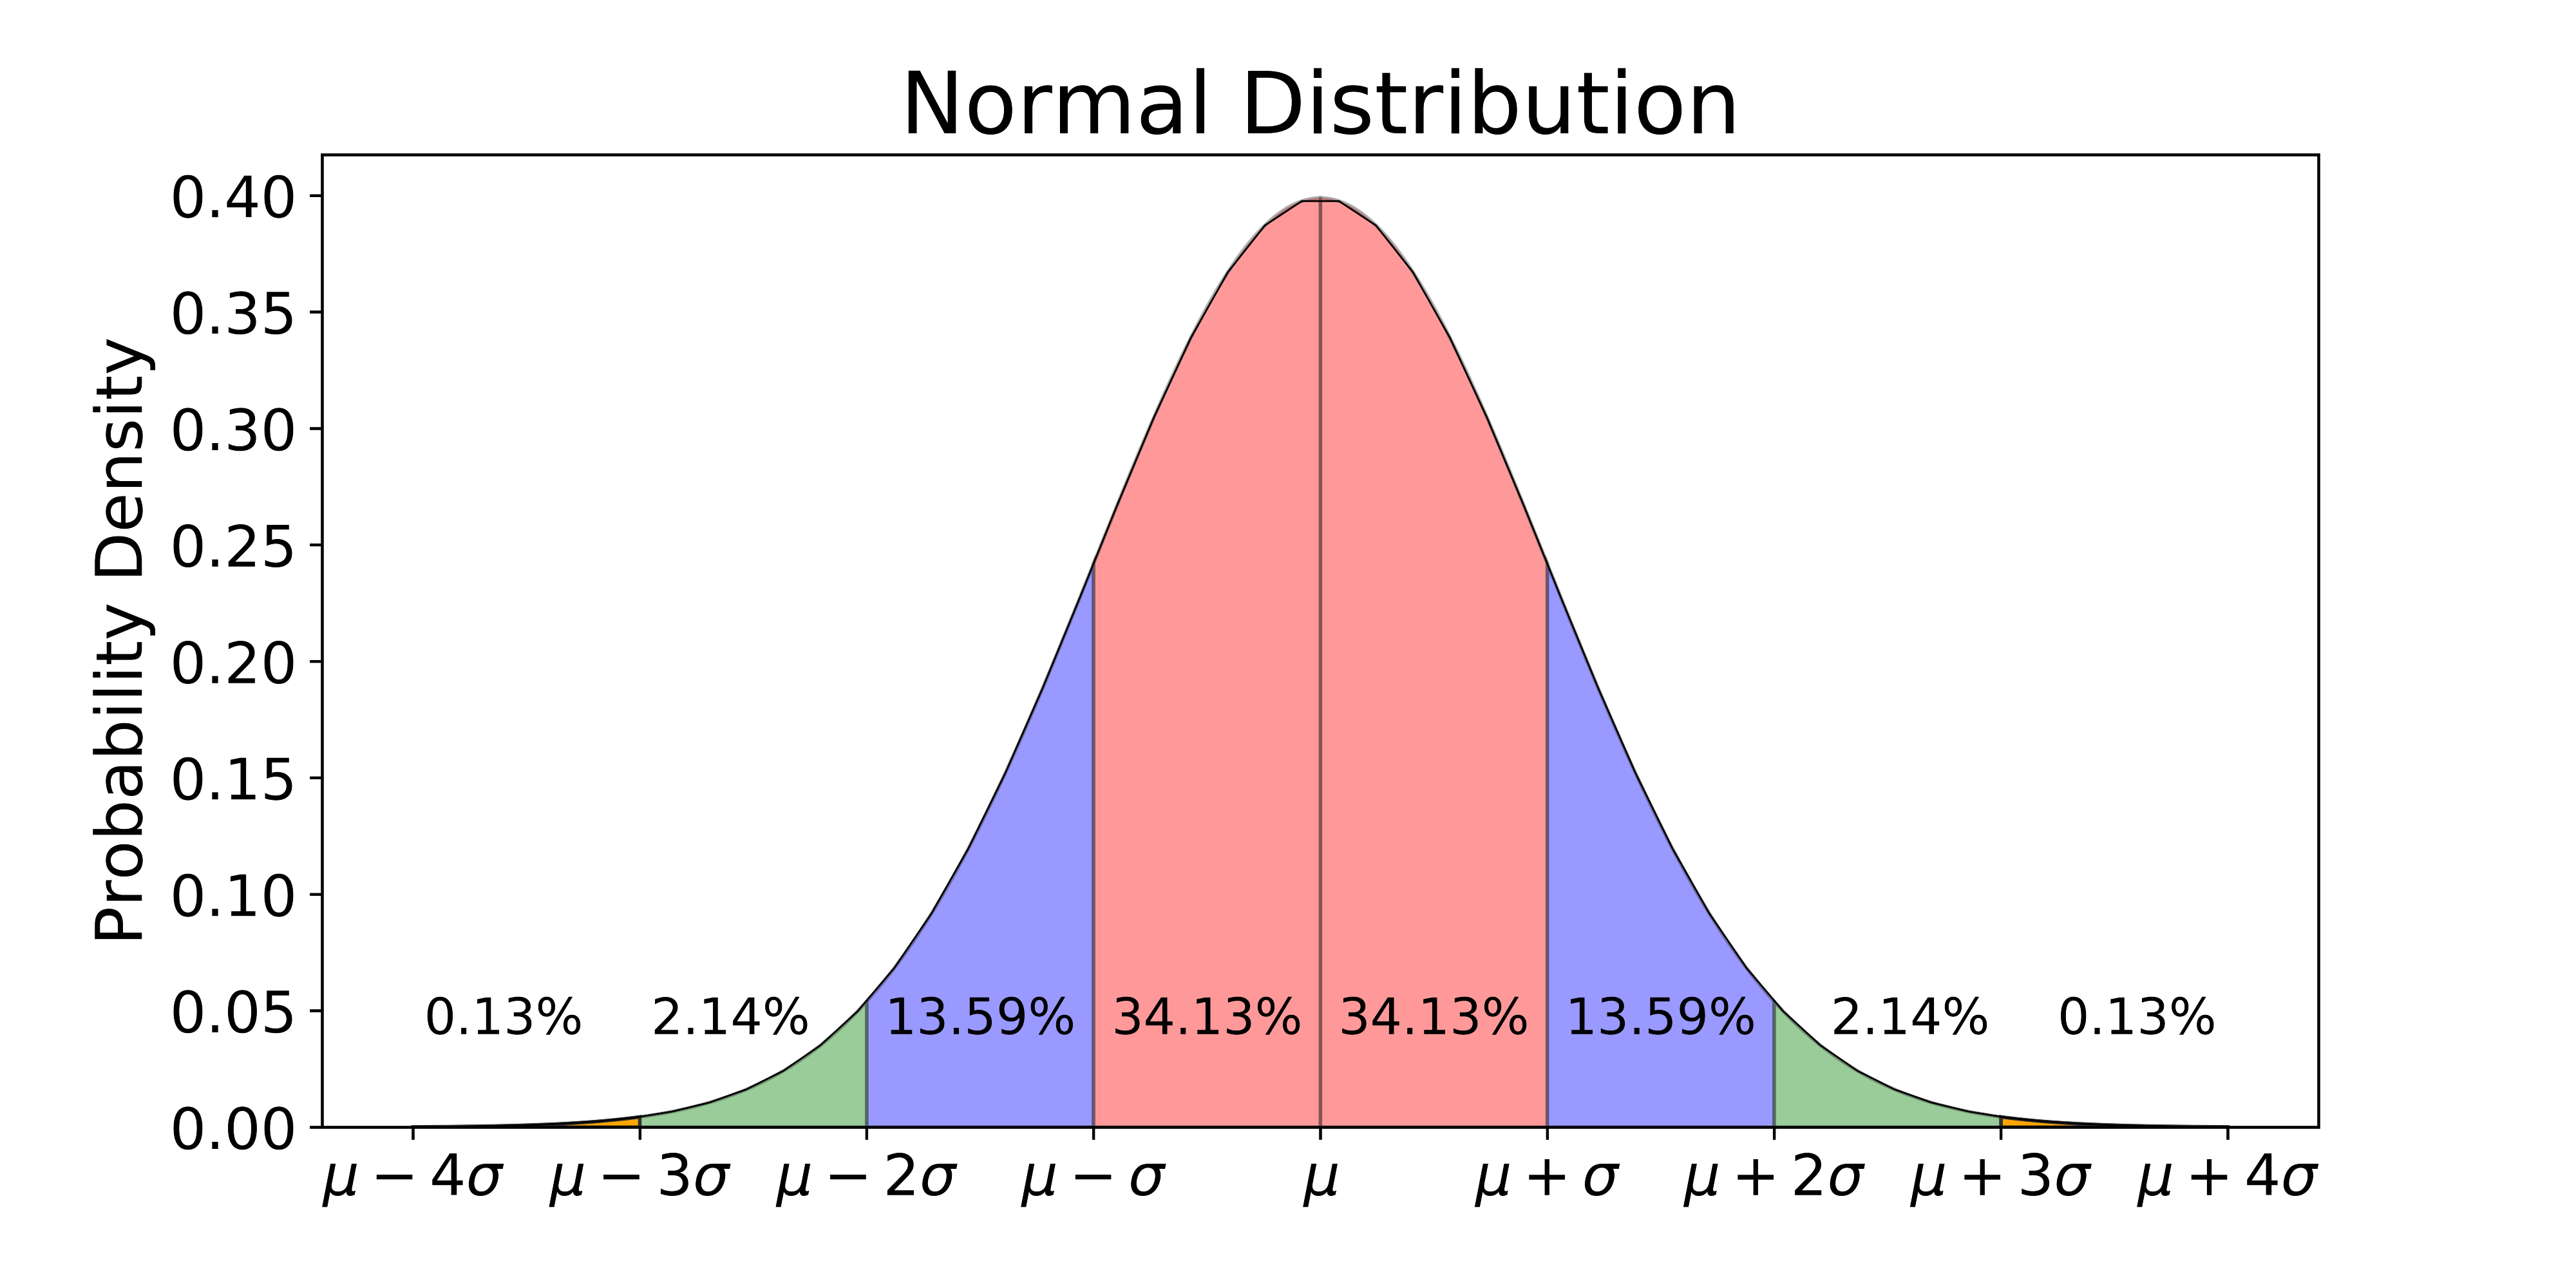
</div>

In [ ]:
n_p= 500 # number of points

# INPUT VARIABLES
# each variable will have a chosen mean and distrubition
# ----------------------------
# Wall

L = np.sort(np.round(np.random.normal(6,1,n_p),2)) # m | length of wall (mean: 6, std:1)
H = np.sort(np.round(np.random.normal(2.5,0.4,n_p),2))  # m | height of wall (mean: 2.5, std:0.4)
t = np.sort(np.round(np.random.normal(0.2,0.022,n_p),2))  # m | thickess of wall (mean: 0.2, std:0.022)
E_eff = np.sort(np.round(np.random.normal(8000E03,1600E03,n_p),2)) # kPa | effective modulus of elasticity (mean: 8000e03, std:1600e03)
M_wy = 500.0 # kNm | bending strength
d_w_b = 1.5 # - | maximum bending ductility
G_eff = np.sort(np.round(np.random.normal(400E03,66E03,n_p),2)) # kPa | effective shear modulus (mean: 400e03, std:66e03)
V_wy = np.sort(np.round(np.random.normal(300,50,n_p),2)) # kN | shear strength (mean: 300, std:50)
d_w_s = 1.3 # - | maximum shear ductility
q = np.sort(np.round(np.random.normal(20,5,n_p),2)) # kN/m | vertical load at top of wall
e_r = 0.1 # - | distance of rotation centre from edge wrt L
 
# Hold-down
k_h = 1000.0 # kN/m | stiffness
F_hy = np.sort(np.round(np.random.normal(480,50,n_p),2)) # kN | strength (mean: 480, std:48)
d_h = 10.0 # - | maximum ductility
e_h = 0.1 # - | distance of hold-down from edge wrt L
 
# Angle-bracket
k_a = 3000.0 # kN/m | stiffness
F_ay = 80.0 # kN | strength (mean: 160, std:48)
d_a = 5.0 # - | maximum ductility
 
# Strength Analysis
R_w_b = M_wy / L # kN | lateral resistance from bending of wall
R_w_s = V_wy # kN | lateral resistance from shear of wall
R_h = (F_hy * (1 - e_h - e_r) + q * L * (0.5 - e_r)) * L / H # kN | lateral resistance from overturning of wall
R_a = F_ay # kN | lateral resistance from shear in angle-brackets of wall
 
# ----------------------------

# OUTPUT VARIABLES :
# initialisation of the output as NaN
F= np.nan
D= np.nan


In [ ]:
# Creating the dataset

data = {'L':L, 
        'H':H, 
        't':t, 
        'E_eff':E_eff, 
        'M_wy':M_wy, 
        'd_w_b':d_w_b,
        'G_eff':G_eff,
        'V_wy':V_wy,
       'd_w_s':d_w_s,
        'q':q, 
        'e_r':e_r, 
        'k_h':k_h, 
        'F_hy':F_hy, 
        'd_h':d_h, 
        'e_h':e_h, 
        'k_a':k_a, 
        'F_ay':F_ay, 
        'd_a':d_a,
       'R_w_b':R_w_b,
        'R_w_s':R_w_s, 
        'R_h':R_h, 
        'R_a':R_a,
        'F':F,
        'D':D

}

data = pd.DataFrame(data)
print("dataset size:",data.shape)

dataset size: (500, 24)


In [ ]:
data.head(10)

,L,H,t,E_eff,M_wy,d_w_b,G_eff,V_wy,d_w_s,q,e_r,k_h,F_hy,d_h,e_h,k_a,F_ay,d_a,R_w_b,R_w_s,R_h,R_a,F,D
0,3.19,1.23,0.13,2698861.25,500.0,1.5,219473.01,134.31,1.3,3.83,0.1,1000.0,330.03,10.0,0.1,3000.0,80.0,5.0,156.739812,134.31,697.419793,80.0,NaN,NaN
1,3.40,1.48,0.14,3351794.67,500.0,1.5,233475.52,154.20,1.3,5.82,0.1,1000.0,332.92,10.0,0.1,3000.0,80.0,5.0,147.058824,154.20,630.036541,80.0,NaN,NaN
2,3.43,1.53,0.14,3929956.25,500.0,1.5,236176.04,171.20,1.3,6.27,0.1,1000.0,337.88,10.0,0.1,3000.0,80.0,5.0,145.772595,171.20,625.260843,80.0,NaN,NaN
3,3.62,1.64,0.15,4169316.21,500.0,1.5,237199.76,186.66,1.3,6.85,0.1,1000.0,343.18,10.0,0.1,3000.0,80.0,5.0,138.121547,186.66,627.899595,80.0,NaN,NaN
4,3.76,1.65,0.15,4278407.13,500.0,1.5,238135.41,191.16,1.3,7.32,0.1,1000.0,356.58,10.0,0.1,3000.0,80.0,5.0,132.978723,191.16,675.143959,80.0,NaN,NaN
5,3.76,1.67,0.15,4335056.09,500.0,1.5,242606.63,191.21,1.3,8.03,0.1,1000.0,358.56,10.0,0.1,3000.0,80.0,5.0,132.978723,191.21,673.029013,80.0,NaN,NaN
6,3.83,1.71,0.15,4512100.64,500.0,1.5,253825.03,192.84,1.3,8.30,0.1,1000.0,361.30,10.0,0.1,3000.0,80.0,5.0,130.548303,192.84,675.861958,80.0,NaN,NaN
7,3.88,1.72,0.15,4642149.16,500.0,1.5,256864.00,193.39,1.3,8.67,0.1,1000.0,362.92,10.0,0.1,3000.0,80.0,5.0,128.865979,193.39,685.297872,80.0,NaN,NaN
8,3.90,1.74,0.15,4839474.88,500.0,1.5,257554.74,200.14,1.3,8.96,0.1,1000.0,363.88,10.0,0.1,3000.0,80.0,5.0,128.205128,200.14,683.803586,80.0,NaN,NaN
9,3.93,1.74,0.15,4844176.98,500.0,1.5,261749.45,203.07,1.3,9.00,0.1,1000.0,367.05,10.0,0.1,3000.0,80.0,5.0,127.226463,203.07,695.176345,80.0,NaN,NaN


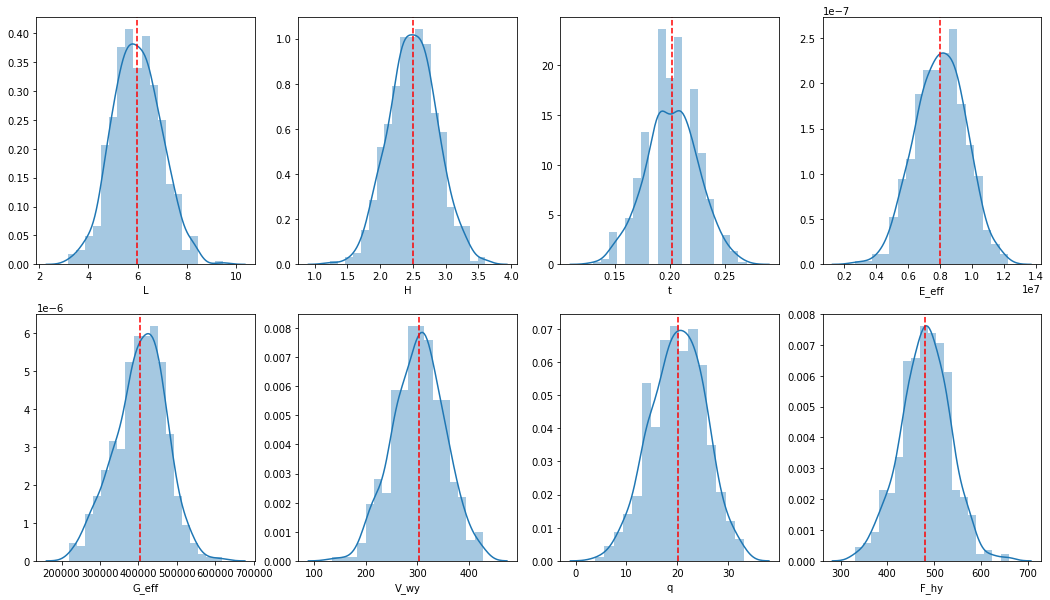

In [ ]:
# distrubition of the data points

f, axes = plt.subplots(nrows=2, ncols=4, figsize=(18,10))

sns.distplot(data["L"],ax=axes[0,0])
axes[0,0].axvline(data["L"].mean(), color='r', linestyle='--')

sns.distplot(data["H"],ax=axes[0,1])
axes[0,1].axvline(data["H"].mean(), color='r', linestyle='--')

sns.distplot(data["t"],ax=axes[0,2])
axes[0,2].axvline(data["t"].mean(), color='r', linestyle='--')

sns.distplot(data["E_eff"],ax=axes[0,3])
axes[0,3].axvline(data["E_eff"].mean(), color='r', linestyle='--')

sns.distplot(data["G_eff"],ax=axes[1,0])
axes[1,0].axvline(data["G_eff"].mean(), color='r', linestyle='--')

sns.distplot(data["V_wy"],ax=axes[1,1])
axes[1,1].axvline(data["V_wy"].mean(), color='r', linestyle='--')

sns.distplot(data["q"],ax=axes[1,2])
axes[1,2].axvline(data["q"].mean(), color='r', linestyle='--')

sns.distplot(data["F_hy"],ax=axes[1,3])
axes[1,3].axvline(data["F_hy"].mean(), color='r', linestyle='--')

plt.show()

In [ ]:
# Assigning F and D for each data point
def iter_rows(data):
  '''Takes dataframe and returns new dataframe with the F and D added
  
  Parameters:
  data : pandas DataFrame

  Returns:               
  data : pandas DataFrame
  
  '''
  # iterating through each row and calculting the response F-D
  for index,row in data.iterrows():
    D,F=force_dep(row["L"],	row["H"],	
                                                      row["t"],	row["E_eff"],	
                                                      row["M_wy"],	row["d_w_b"],	
                                                      row["G_eff"],	row["V_wy"],	
                                                      row["d_w_s"],	row["q"],	
                                                      row["e_r"],	row["k_h"],	
                                                      row["F_hy"],	row["d_h"],	
                                                      row["e_h"],	row["k_a"],	
                                                      row["F_ay"],	row["d_a"],	
                                                      row["R_w_b"],	row["R_w_s"],	
                                                      row["R_h"],	row["R_a"],tol,graph=False)
    for i,_ in enumerate(F):
      row["F"]=F[i] # assigning the force
      row["D"]=D[i] # assigning the displacement
      data.loc[-1] = row  # adding a row
      data.index = data.index + 1  # shifting index
      data = data.sort_index()  # sorting by index 

  data['D'] = data['D'] * 1E03 # converting to mm
  data=data.sample(frac=1).reset_index(drop=True)
  data.drop_duplicates(ignore_index=True,inplace=True) # remove duplicates
  data.dropna(inplace=True) # droping NaN values
  data = data[data.F != 0] # droping F==0 
  
  return data

In [ ]:
df=iter_rows(data)
print("dataset size:",df.shape)
df

dataset size: (1118, 24)


,L,H,t,E_eff,M_wy,d_w_b,G_eff,V_wy,d_w_s,q,e_r,k_h,F_hy,d_h,e_h,k_a,F_ay,d_a,R_w_b,R_w_s,R_h,R_a,F,D
0,3.83,1.71,0.15,4512100.64,500.0,1.5,253825.03,192.84,1.3,8.30,0.1,1000.0,361.30,10.0,0.1,3000.0,80.0,5.0,130.548303,192.84,675.861958,80.0,80.000000,177.214720
2,5.49,2.34,0.19,7252449.84,500.0,1.5,378840.28,281.41,1.3,17.80,0.1,1000.0,459.07,10.0,0.1,3000.0,80.0,5.0,91.074681,281.41,953.347415,80.0,80.000000,160.586449
4,7.63,3.15,0.24,10482633.64,500.0,1.5,508880.94,385.45,1.3,28.88,0.1,1000.0,569.83,10.0,0.1,3000.0,80.0,5.0,65.530799,385.45,1317.702841,80.0,65.530799,22.127747
6,7.47,3.07,0.24,10335328.39,500.0,1.5,493220.35,376.94,1.3,27.72,0.1,1000.0,561.18,10.0,0.1,3000.0,80.0,5.0,66.934404,376.94,1293.919238,80.0,66.934404,22.597827
7,7.05,2.91,0.23,9687547.02,500.0,1.5,472371.60,356.49,1.3,25.79,0.1,1000.0,534.06,10.0,0.1,3000.0,80.0,5.0,70.921986,356.49,1211.281577,80.0,70.921986,23.972952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2109,6.87,2.83,0.22,9493887.48,500.0,1.5,464037.61,349.42,1.3,25.09,0.1,1000.0,528.36,10.0,0.1,3000.0,80.0,5.0,72.780204,349.42,1193.475141,80.0,72.780204,24.636836
2110,5.77,2.44,0.20,7813279.70,500.0,1.5,400020.18,296.90,1.3,19.48,0.1,1000.0,474.73,10.0,0.1,3000.0,80.0,5.0,86.655113,296.90,1004.414736,80.0,80.000000,27.189579
2111,6.01,2.53,0.20,8150847.70,500.0,1.5,414540.81,308.67,1.3,20.68,0.1,1000.0,486.33,10.0,0.1,3000.0,80.0,5.0,83.194676,308.67,1042.316248,80.0,80.000000,27.168749
2113,6.99,2.86,0.23,9609211.39,500.0,1.5,469201.64,351.99,1.3,25.37,0.1,1000.0,531.29,10.0,0.1,3000.0,80.0,5.0,71.530758,351.99,1212.169921,80.0,71.530758,24.177897


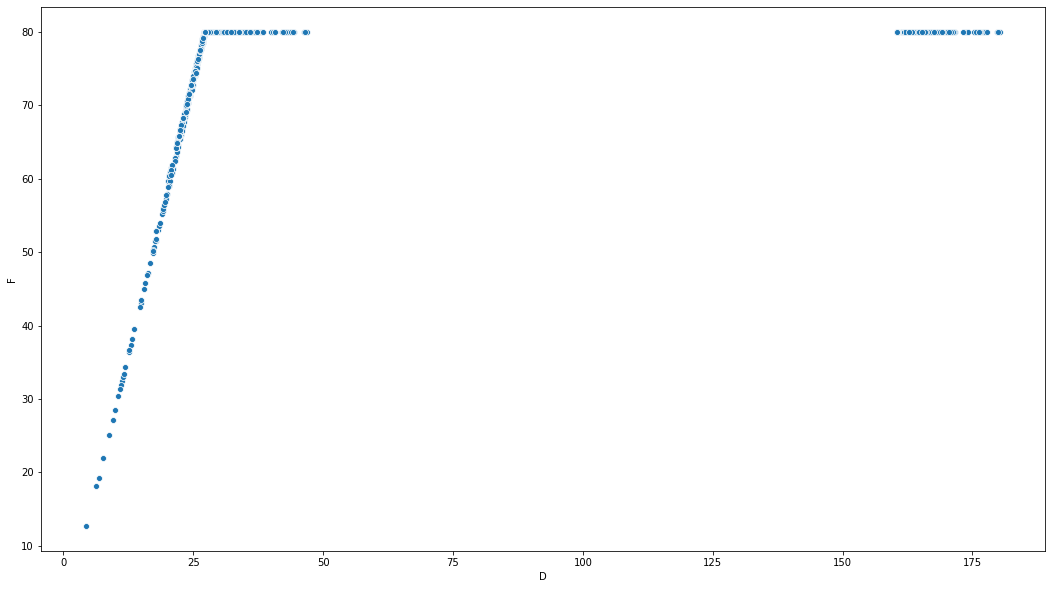

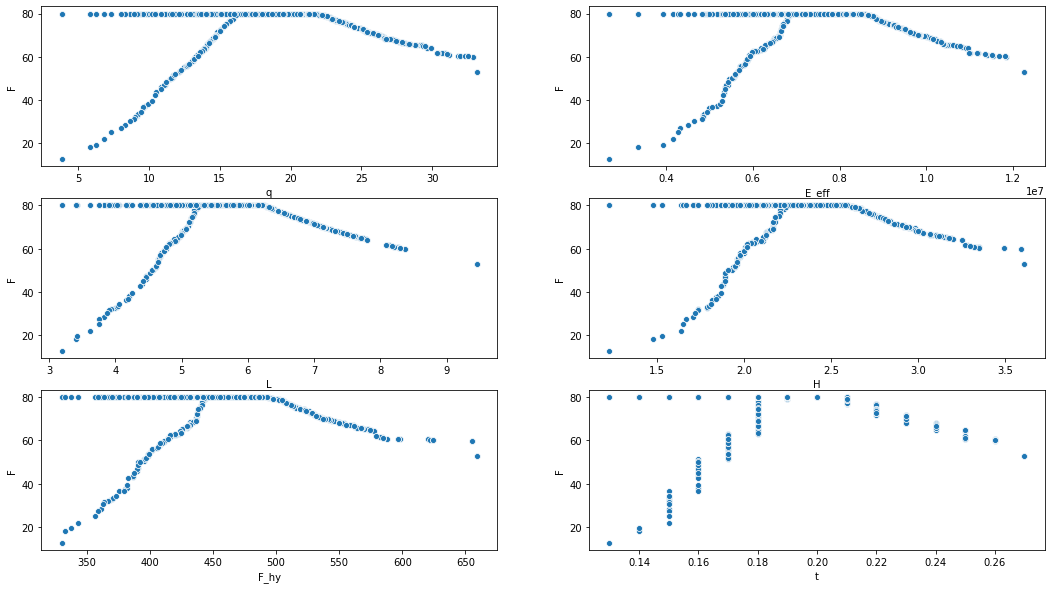

In [ ]:
# inspecting created data points

plt.figure(figsize=(18,10))
sns.scatterplot(data=df, x="D", y="F")
plt.show()
f, axes = plt.subplots(nrows=3, ncols=2, figsize=(18,10))


sns.scatterplot(data=df, x="q", y="F",ax=axes[0,0])
sns.scatterplot(data=df, x="E_eff", y="F",ax=axes[0,1])
sns.scatterplot(data=df, x="L", y="F",ax=axes[1,0])
sns.scatterplot(data=df, x="H", y="F",ax=axes[1,1])
sns.scatterplot(data=df, x="F_hy", y="F",ax=axes[2,0])
sns.scatterplot(data=df, x="t", y="F",ax=axes[2,1])


plt.show()

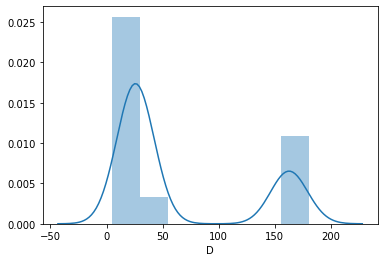

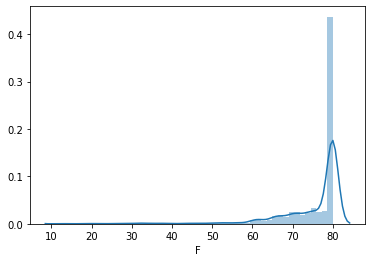

In [ ]:
# the distribution of the outputs

sns.distplot(df["D"])
plt.show()
sns.distplot(df["F"])
plt.show()

## 2- Machine learning model

After creating the dataset, we feed it to a machine learning alghorithm and see the outcome.

In [ ]:
X=df.drop(["D"],axis=1) # Assigning the inputs(including F) to X
y=df["D"] # setting D as an output

# splitting the data to 66.66% for training and 33.33% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)

print("training data shape: X:",X_train.shape)
print("y:",y_train.shape)
print("testing data shape: X:",X_test.shape)
print("y:",y_test.shape)

training data shape: X: (782, 23)
y: (782,)
testing data shape: X: (336, 23)
y: (336,)


In [ ]:
# inialisation of RandomForestRegressor class
model=RandomForestRegressor()

# Training
model.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
y_pred=model.predict(X_test)

y_=model.predict(X_train)

print("error on training data: (mm)",np.sqrt(mean_squared_error(y_train,y_)))
print("error on test data: (mm)",np.sqrt(mean_squared_error(y_test,y_pred)))

error on training data: (mm) 42.19735785128332
error on test data: (mm) 73.65687502443205


In [ ]:
results=pd.DataFrame({"y_test":y_test,"y_pred":y_pred})

results.head(10)

,y_test,y_pred
948,171.524609,71.503957
1674,27.135882,110.579962
577,160.521074,53.854692
634,26.045728,26.064904
10,24.440242,24.456714
226,160.471061,142.248687
1110,160.460114,62.920533
192,25.464786,25.452447
84,165.655304,46.298817
602,27.182106,101.516450


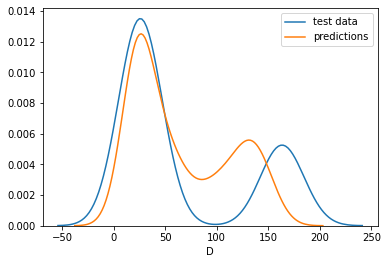

In [ ]:
sns.distplot(y_test,label='test data',hist=False)
sns.distplot(y_pred,label='predictions',hist=False)
plt.legend()
plt.show()

Comparing the results from the model to the datapoint we created at first:

In [ ]:
data_point=iter_rows(datapoint)

In [ ]:
X_1=data_point.drop(["D"],axis=1)

result=pd.DataFrame({"prediction":model.predict(X_1),"true value":data_point["D"]})

result.head(10)

,prediction,true value
0,13.214803,12.600000
1,118.514625,96.750000
3,118.514625,230.083333


*notes:* 
- even though the result of the model are good on the random dataset, the model still predicted poorly on the initial datapoint.
- the big diffrence in the error between train and test data is called "overfitting", which means that the model is not learning well on training data. This kind of behavior was expected since there was only 700 training points, so it can be improved later.


